<a href="https://colab.research.google.com/github/lorenz0leoncin1/ROS-Autonomous-Navavigation-BehaviorTrees/blob/main/Collaborative_Filtering_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Collaborative Filtering Recommendation System
#Lorenzo Leoncini
#Matricola: 47403A

# Step 1: Import Libraries

In [113]:
# Import necessary libraries for data manipulation, visualization, and similarity calculations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import zipfile
from sklearn.preprocessing import MinMaxScaler
import random
import time
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix


# Step 2: Environment Setup and Data Download

In [114]:
# Set environment variables for Kaggle API (remove before submitting)
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

# Download the dataset using Kaggle API
!kaggle datasets download -d gsimonx37/letterboxd

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
letterboxd.zip: Skipping, found more recently modified local copy (use --force to force download)


# Step 3: Extract Dataset


In [115]:
# Paths and specific files
zip_file_path = 'letterboxd.zip'
extract_path = 'data/'
files_to_extract = ['actors.csv', 'genres.csv', 'movies.csv']

def extract_specific_files(zip_path, extract_dir, files_list):
    # Ensure the extraction directory exists
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get the list of all files in the ZIP archive
        all_files = zip_ref.namelist()

        # Filter the files you want to extract
        files_to_extract = [file for file in all_files if file in files_list]

        # Extract only the specified files
        for file in files_to_extract:
            zip_ref.extract(file, extract_dir)
            print(f"Extracted: {file}")

# Call the function to extract specific files
extract_specific_files(zip_file_path, extract_path, files_to_extract)

Extracted: actors.csv
Extracted: genres.csv
Extracted: movies.csv


# Step 4: Load the datasets into the Dataframes

In [116]:
RANDOM_SUBSAMPLING = True
SUBSAMPLING_SIZE = 0.01

def load_and_process_csv(file_path, chunk_size=40000, subsampling_enabled=False):
    chunks = []

    # Read and process the file in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunks.append(chunk)

    # Combine chunks into a single DataFrame if necessary, check and drop duplicates
    combined_df = pd.concat(chunks, ignore_index=True)
    combined_df = combined_df.drop_duplicates()
    print(f"Shape of the DataFrame before subsampling for {file_path}: {combined_df.shape}")

    # Apply subsampling if enabled
    if subsampling_enabled:
        combined_df = combined_df.sample(frac=SUBSAMPLING_SIZE, random_state=42)
        print(f"Shape of the DataFrame after subsampling for {file_path}: {combined_df.shape}")

    return combined_df

df_actors = load_and_process_csv('data/actors.csv', subsampling_enabled=RANDOM_SUBSAMPLING)
df_genres = load_and_process_csv('data/genres.csv', subsampling_enabled=RANDOM_SUBSAMPLING)
df_movies = load_and_process_csv('data/movies.csv', subsampling_enabled=RANDOM_SUBSAMPLING)


Shape of the DataFrame before subsampling for data/actors.csv: (5797504, 3)
Shape of the DataFrame after subsampling for data/actors.csv: (57975, 3)
Shape of the DataFrame before subsampling for data/genres.csv: (1046849, 2)
Shape of the DataFrame after subsampling for data/genres.csv: (10468, 2)
Shape of the DataFrame before subsampling for data/movies.csv: (941597, 7)
Shape of the DataFrame after subsampling for data/movies.csv: (9416, 7)


#Step 5: Pre-Processing of 'movies' dataset

In [117]:
df_movies.head()

,id,name,date,tagline,description,minute,rating
920492,1920493,Nesalauztie,2001.0,NaN,NaN,25.0,NaN
861368,1861369,U2 Live at Los Angeles 2018,2018.0,NaN,NaN,NaN,NaN
847808,1847809,ONDAR Florent Peyre,NaN,NaN,NaN,NaN,NaN
521859,1521860,Seed Corn Should Not Be Ground – A Portrait of...,1967.0,NaN,Tetzlaff's documentary combines historic film ...,20.0,NaN
204483,1204484,Computer Movie No.2,1969.0,NaN,Computer Movie No. 2 is a CGI animation create...,8.0,NaN


In [118]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9416 entries, 920492 to 552366
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           9416 non-null   int64  
 1   name         9416 non-null   object 
 2   date         8483 non-null   float64
 3   tagline      1388 non-null   object 
 4   description  7806 non-null   object 
 5   minute       7657 non-null   float64
 6   rating       936 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 588.5+ KB


In [119]:
# Convert 'date' column to datetime format
df_movies['date'] = pd.to_datetime(df_movies['date'], errors='coerce', format='%Y')

# Extract the year and ensure it is in integer format
df_movies['date'] = df_movies['date'].dt.year.astype('Int64')


In [120]:
from sklearn.preprocessing import MinMaxScaler

# Creation of scaler
scaler = MinMaxScaler()

# Adapt and transform only 'minute' column
df_movies[['minute']] = scaler.fit_transform(df_movies[['minute']])


In [121]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9416 entries, 920492 to 552366
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           9416 non-null   int64  
 1   name         9416 non-null   object 
 2   date         8483 non-null   Int64  
 3   tagline      1388 non-null   object 
 4   description  7806 non-null   object 
 5   minute       7657 non-null   float64
 6   rating       936 non-null    float64
dtypes: Int64(1), float64(2), int64(1), object(3)
memory usage: 597.7+ KB


### Missing Data Analysis

After examining the `movies` dataset, we observed the following percentages of missing values in key columns:

- **`date`:** 9.76% missing
- **`tagline`:** 85.20% missing
- **`description`:** 17.08% missing
- **`minute`:** 19.28% missing
- **`rating`:** 90.34% missing

#### Analysis of Missing Data

1. **High Percentage of Missing Values:**

- **`tagline` (85.20%)**: This column has an extremely high percentage of missing data. Since `tagline` was not consistently recorded, it will be removed from the dataset to avoid introducing significant bias or reducing the robustness of the analysis.

- **`rating` (90.34%)**: Although this column also has a high percentage of missing data, it will be retained for future use. Missing values in `rating` will be managed by assigning an average rating or a default value when needed to ensure the system remains effective.

2. **Moderate Percentage of Missing Values:**
   - **`date` (9.76%)**, **`description` (17.08%)**, and **`minute` (19.28%)** have moderate levels of missing data. While these columns have more complete data than `tagline` and `rating`, the missing values still need to be handled appropriately to ensure accurate analysis results.

#### Decision on Handling Missing Data

Given the high percentages of missing values in the `tagline` column, we have decided to **drop this column** from the dataset. The rationale behind this decision is as follows:

- **`tagline`:** With over 85% of the values missing, the tagline column lacks sufficient data to contribute meaningfully to any analysis. Including this column could potentially skew results and reduce analytical clarity.

We are also going to drop the column `description` just because we are not gonna use it.

By dropping these columns, we aim to streamline our dataset and focus on more complete data, ensuring a more robust and reliable analysis. For the remaining columns (`date`, `rating`, `minute`), we will consider appropriate imputation or data cleaning strategies to handle the missing values effectively.


In [122]:
# Let's find the missing values of the columns: date, tagline,description,minute, rating

# Calculate the percentage of missing values for each specified column
missing_values = df_movies[['date', 'tagline', 'description', 'minute', 'rating']].isnull().sum()
missing_percentage = (missing_values / len(df_movies)) * 100

# Display the results
print("Missing Values Percentage:")
print(missing_percentage)


Missing Values Percentage:
date            9.908666
tagline        85.259133
description    17.098556
minute         18.680969
rating         90.059473
dtype: float64


In [123]:
# Drop 'tagline' and 'rating' columns due to high percentage of missing values
df_movies.drop(columns=['tagline', 'description'], inplace=True)

# Display the updated DataFrame
print(df_movies.info())


<class 'pandas.core.frame.DataFrame'>
Index: 9416 entries, 920492 to 552366
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      9416 non-null   int64  
 1   name    9416 non-null   object 
 2   date    8483 non-null   Int64  
 3   minute  7657 non-null   float64
 4   rating  936 non-null    float64
dtypes: Int64(1), float64(2), int64(1), object(1)
memory usage: 450.6+ KB
None


### Analysis of remaining columns

In [124]:
# Drop rows where 'name' is missing
df_movies = df_movies.dropna(subset=['name'])


In [125]:
# Drop rows where 'date' is missing
df_movies = df_movies.dropna(subset=['date'])

In [126]:
# Drop rows where 'minute' is missing
df_movies = df_movies.dropna(subset=['minute'])

In [127]:
# Display updated DataFrame information
print(df_movies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7154 entries, 920492 to 552366
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      7154 non-null   int64  
 1   name    7154 non-null   object 
 2   date    7154 non-null   Int64  
 3   minute  7154 non-null   float64
 4   rating  932 non-null    float64
dtypes: Int64(1), float64(2), int64(1), object(1)
memory usage: 342.3+ KB
None


In [128]:
# Calculate average rating of films with ratings
average_rating = df_movies['rating'].dropna().mean()

# Assign the average rating to films without ratings
df_movies['rating'].fillna(average_rating, inplace=True)

In [129]:
# Count movies with a rating above 3.5 using a query
num_films_above_325 = df_movies.query('rating > 3.25').shape[0]

print(f"Numero di film con valutazione superiore a 3.25: {num_films_above_325}")


Numero di film con valutazione superiore a 3.25: 514


In [130]:
# Check for missing data in the final DataFrame
missing_values_final = df_movies.isnull().sum()
print("Missing Values Percentage After Final Processing:")
print((missing_values_final / len(df_movies)) * 100)

# Check for duplicate rows
duplicates = df_movies.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing Values Percentage After Final Processing:
id        0.0
name      0.0
date      0.0
minute    0.0
rating    0.0
dtype: float64
Number of duplicate rows: 0


In [131]:
# Group by name and count unique IDs for each name
name_id_counts = df_movies.groupby('name')['id'].nunique()

# Filter names with more than one unique ID
duplicate_names = name_id_counts[name_id_counts > 1]

# Print the results
print("Movies with the same name but different IDs:")
print(duplicate_names)


Movies with the same name but different IDs:
name
Abracadabra                         2
Aladino y la lámpara maravillosa    2
All the Women in the World          2
Alone                               2
Ananda                              2
Anna                                2
Another World                       2
Antidote                            2
Avalanche                           2
Balance                             2
Bite                                2
Blue                                4
Chaos                               3
Chimera                             2
Departure                           2
Destiny                             2
Fish                                2
Forest                              2
Garden of Eden                      2
Heartless                           2
Heritage                            2
Inside Out                          2
Love                                3
Moby Dick                           2
Mother                              2


# Step 6: Pre-Processing of 'actors' dataset

In [132]:
# Overview of the actors DataFrame
print(df_actors.info())
print(df_actors.head())

<class 'pandas.core.frame.DataFrame'>
Index: 57975 entries, 524783 to 3890768
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57975 non-null  int64 
 1   name    57975 non-null  object
 2   role    44198 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB
None
              id                 name               role
524783   1017751         Robert Morse  J. Pierpont Finch
4631798  1545017      Daniel Bermudez     Johnny Thunder
890051   1038132  Shinnosuke Kasahara              Yoshi
270922   1007073         Gregg Daniel  English Professor
2424699  1176293      Kanako Miyamoto        Kō Sawatari


In [133]:
# Check for missing values in the actors DataFrame
missing_values_actors = df_actors.isnull().sum()
missing_percentage_actors = (missing_values_actors / len(df_actors)) * 100

print("Missing Values Percentage in Actors Table:")
print(missing_percentage_actors)

Missing Values Percentage in Actors Table:
id       0.000000
name     0.000000
role    23.763691
dtype: float64


In [134]:
# Deleting the role column
df_actors = df_actors.drop(columns=['role'])

print(df_actors.head())

              id                 name
524783   1017751         Robert Morse
4631798  1545017      Daniel Bermudez
890051   1038132  Shinnosuke Kasahara
270922   1007073         Gregg Daniel
2424699  1176293      Kanako Miyamoto


In [135]:
# Assume df_actor_movie is already defined
# Group by 'id' and 'actor_name' and count the number of rows in each group
grouped = df_actors.groupby(['id', 'name']).size().reset_index(name='count')

# Filter to show only groups with more than one row
duplicates = grouped[grouped['count'] > 1]

# Display the duplicate associations
print("Duplicate associations between id and name:")
print(duplicates)

# Optional: Display the total number of duplicate associations
print(f"Total number of duplicate associations: {duplicates.shape[0]}")


Duplicate associations between id and name:
Empty DataFrame
Columns: [id, name, count]
Index: []
Total number of duplicate associations: 0


In [136]:
# Remove duplicate rows, keeping only the first occurrence
df_actors = df_actors.drop_duplicates(subset=['id', 'name'])

# Check the updated DataFrame
print(df_actors.head())


              id                 name
524783   1017751         Robert Morse
4631798  1545017      Daniel Bermudez
890051   1038132  Shinnosuke Kasahara
270922   1007073         Gregg Daniel
2424699  1176293      Kanako Miyamoto


In [137]:
# Remove rows where 'name' is missing
df_actors.dropna(subset=['name'], inplace=True)

In [138]:
# Convert all names and roles to lowercase for consistency
df_actors['name'] = df_actors['name'].str.lower()

In [139]:
# Optimize the id column if needed (convert to int32 if applicable)
df_actors['id'] = df_actors['id'].astype('int32')

In [140]:
df_actors.head()

,id,name
524783,1017751,robert morse
4631798,1545017,daniel bermudez
890051,1038132,shinnosuke kasahara
270922,1007073,gregg daniel
2424699,1176293,kanako miyamoto


In [141]:
# Count number of unique actors
num_unique_actors = df_actors['name'].nunique()
print(f"Number of unique actors: {num_unique_actors}")


Number of unique actors: 51234


In [142]:
# List unique actors
unique_actors = df_actors['name'].unique()
print(f"Number of unique actors: {len(unique_actors)}")
print("First 10 unique actors:")
print(unique_actors[:10])


Number of unique actors: 51234
First 10 unique actors:
['robert morse' 'daniel bermudez' 'shinnosuke kasahara' 'gregg daniel'
 'kanako miyamoto' 'rosie alvarez' 'lettie shumate' 'samuel joslin'
 'rajaa mounssif' 'v. larin']


In [143]:
# Check for actors with duplicate names
duplicate_actors = df_actors[df_actors.duplicated(subset=['name'], keep=False)]
print(f"Number of rows with duplicate actors: {duplicate_actors.shape[0]}")


Number of rows with duplicate actors: 11917


In [144]:
# Count the number of participations per actor
actor_participations = df_actors['name'].value_counts()
print(actor_participations.head(10))  # Show the top 10 actors with the most participations


name
mel blanc         9
andy clyde        8
bess flowers      8
jason robards     8
brahmanandam      8
m. s. narayana    7
walt disney       7
bud jamison       7
per oscarsson     7
meena             7
Name: count, dtype: int64


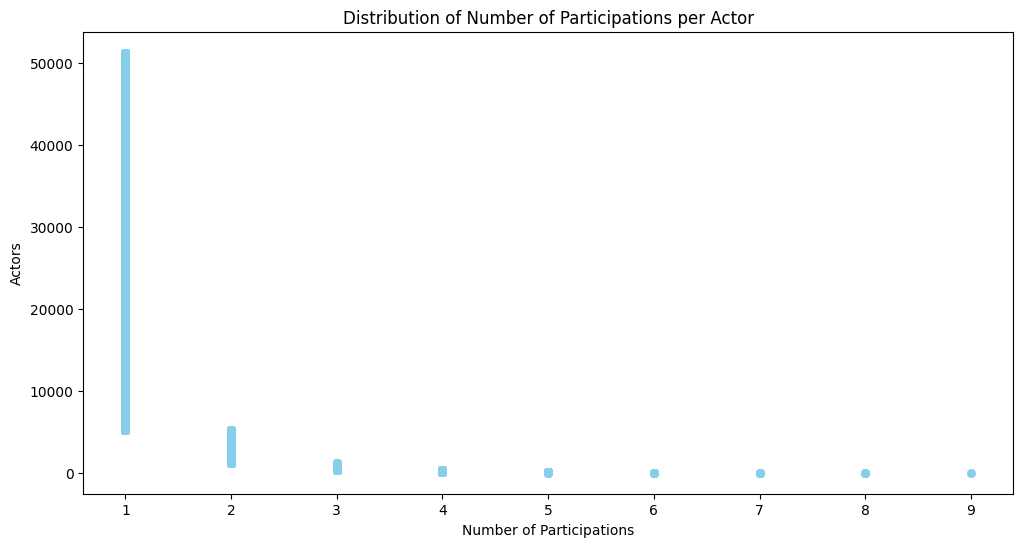

In [145]:
# Count the number of participations for each actor
actor_participations = df_actors['name'].value_counts().reset_index()
actor_participations.columns = ['actor', 'participations']

# Configure the plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='participations', y=actor_participations.index, data=actor_participations, color='skyblue', edgecolor=None)
plt.title('Distribution of Number of Participations per Actor')
plt.xlabel('Number of Participations')
plt.ylabel('Actors')
plt.show()


In [146]:
# Count the total number of duplicate rows in the DataFrame
duplicate_count = df_actors.duplicated().sum()

print(f"Number of duplicate rows in df_actors: {duplicate_count}")


Number of duplicate rows in df_actors: 0


In [147]:
# Find and display duplicate rows
duplicate_rows = df_actors[df_actors.duplicated()]

print("Duplicate rows in df_actors:")
print(duplicate_rows)


Duplicate rows in df_actors:
Empty DataFrame
Columns: [id, name]
Index: []


In [148]:
# Find and display duplicate rows along with their occurrence counts
duplicate_rows_with_count = df_actors[df_actors.duplicated(keep=False)]
duplicate_counts = duplicate_rows_with_count.groupby(list(df_actors.columns)).size().reset_index(name='count')

print("Duplicate rows and their occurrence counts:")
print(duplicate_counts)


Duplicate rows and their occurrence counts:
Empty DataFrame
Columns: [id, name, count]
Index: []


In [149]:
# Remove duplicate rows, keeping only the first occurrence
df_actors_unique = df_actors.drop_duplicates()

print(f"Shape of the DataFrame after removing duplicates: {df_actors_unique.shape}")


Shape of the DataFrame after removing duplicates: (57975, 2)


# Step 7: Set up for creating the matrices

In [150]:
# Ensure actor names are lowercase and stripped of extra spaces

df_actors['name'] = df_actors['name'].str.lower().str.strip()


# Create a mapping between actor names and IDs
actor_to_id = {name: idx for idx, name in enumerate(df_actors['name'].unique())}
id_to_actor = {idx: name for name, idx in actor_to_id.items()}


# Add the 'actor_id' column to the DataFrame
df_actors['actor_id'] = df_actors['name'].map(actor_to_id)


# Check for duplicate actor names with different IDs
grouped = df_actors.groupby('name')['actor_id'].nunique().reset_index()
duplicates = grouped[grouped['actor_id'] > 1]
print("Actors with duplicate names and different IDs:")
print(duplicates)

# Drop the 'name' column and rename 'id' to 'movie_id'
df_actors = df_actors.drop(columns=['name'])
df_actors.rename(columns={'id': 'movie_id'}, inplace=True)

# Map movie_id to continuous range from 0 to num_unique_movies - 1
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(df_actors['movie_id'].unique())}
df_actors['movie_index'] = df_actors['movie_id'].map(movie_id_to_index)

# Randomly shuffle the movie indices
shuffled_movie_indices = np.random.permutation(df_actors['movie_id'].unique())
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(shuffled_movie_indices)}
df_actors['movie_index'] = df_actors['movie_id'].map(movie_id_to_index)

Actors with duplicate names and different IDs:
Empty DataFrame
Columns: [name, actor_id]
Index: []


# Step 8: Implementation of utility sparse Matrix and Similarity Matrix with cosine similarity

In [151]:
def create_sparse_matrix_from_scratch(rows, cols, data, num_rows, num_cols):

    # Initialize empty lists for data, row indices, and column indices
    data_list = []
    row_indices_list = []
    col_indices_list = []

    # Populate the lists with the data
    for r, c, d in zip(rows, cols, data):
        row_indices_list.append(r)
        col_indices_list.append(c)
        data_list.append(d)

    # Convert lists to numpy arrays for efficiency
    data_array = np.array(data_list)
    row_indices_array = np.array(row_indices_list)
    col_indices_array = np.array(col_indices_list)

    # Return the COO-format sparse matrix representation
    return data_array, row_indices_array, col_indices_array, num_rows, num_cols


In [152]:
from scipy.sparse import csr_matrix
# Create the sparse matrix
rows = df_actors['movie_index']
cols = df_actors['actor_id']
data = [1] * len(df_actors)

num_unique_movies = len(movie_id_to_index)
num_unique_actors = df_actors['actor_id'].nunique()

# Create the sparse matrix
# Pass num_unique_movies and num_unique_actors as arguments instead of num_rows and num_cols
data_array, row_indices_array, col_indices_array, num_rows, num_cols = create_sparse_matrix_from_scratch(rows, cols, data, num_unique_movies, num_unique_actors)

# Convert arrays to CSR matrix
utility_matrix_csr = csr_matrix((data_array, (row_indices_array, col_indices_array)), shape=(num_rows, num_cols))

#utility_matrix_sparse = coo_matrix((data, (rows, cols)), shape=(num_unique_movies, num_unique_actors))

#Step 9: Informations about the Sparse Utility Matrix

In [153]:
density = utility_matrix_csr.nnz / (num_unique_movies * num_unique_actors)
print(f"Densità della matrice di utilità: {density:.9f}")


Densità della matrice di utilità: 0.000021385


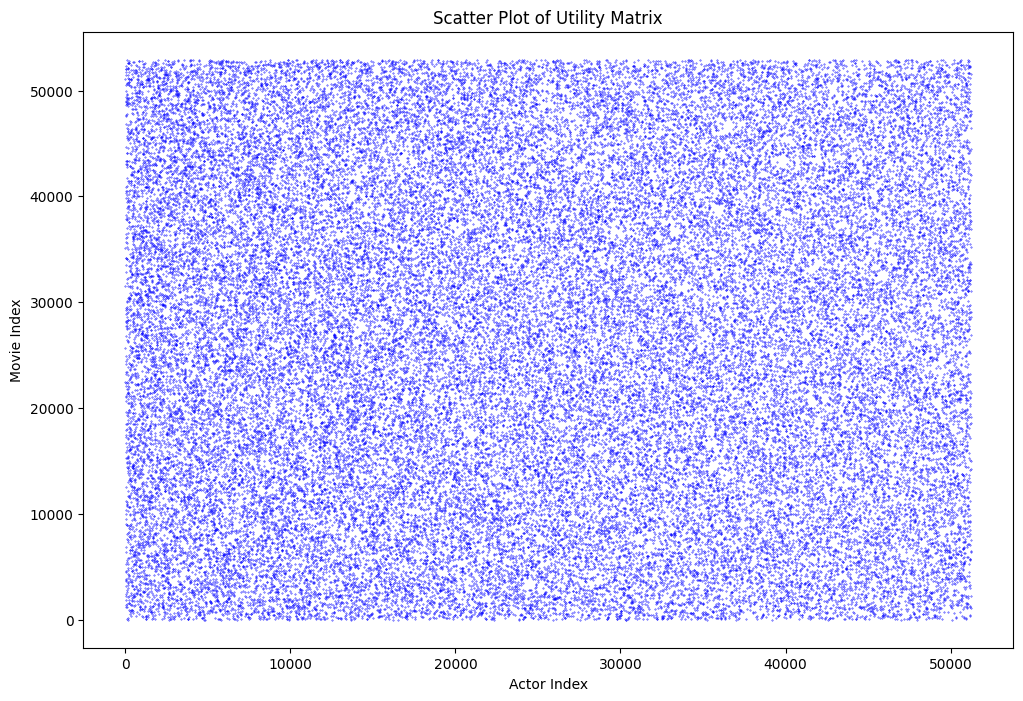

In [154]:
# Plot sparse matrix scatter plot
def plot_sparse_matrix(utility_matrix_csr):
    # Get the non-zero indices from the sparse matrix
    movie_indices, actor_indices = utility_matrix_csr.nonzero()

    plt.figure(figsize=(12, 8))  # Increase figure size
    plt.scatter(actor_indices, movie_indices, marker='o', s=0.1, color='b')  # Increase point size
    plt.title('Scatter Plot of Utility Matrix')
    plt.xlabel('Actor Index')
    plt.ylabel('Movie Index')
    plt.show()

# Call the function to plot the utility matrix
plot_sparse_matrix(utility_matrix_csr)


## Cosine Similarity
Cosine similarity is a technique used to measure how similar two items are by comparing the angles between their vector representations. Imagine each item is represented as a point in a multi-dimensional space.

In [155]:
# Calculate similarity matrix for actors
similarity_matrix = cosine_similarity(utility_matrix_csr.T)
print(f"Shape of recalculated similarity_matrix: {similarity_matrix.shape}")

Shape of recalculated similarity_matrix: (51234, 51234)


# Step 10: Recommendation Algorithm


In [156]:
# Function to check if an actor has enough data for recommendations
def can_recommend(actor_name, df_actors, utility_matrix_csr):
    actor_id = actor_to_id.get(actor_name, None)
    if actor_id is None:
        return False

    # Get the movies the actor has participated in
    movies_seen_by_actor = df_actors[df_actors['actor_id'] == actor_id]['movie_index'].values
    return len(movies_seen_by_actor) > 0  # Check if the actor has participated in any movies


In [157]:
def get_random_films_above_rating(df_movies, rating_threshold=3.5, num_films=5):
    films_above_rating = df_movies[df_movies['rating'] > rating_threshold]
    if len(films_above_rating) < num_films:
        return films_above_rating.sample(n=len(films_above_rating))
    return films_above_rating.sample(n=num_films)

In [158]:
def recommend_movies_for_actor(actor_name, df_actors, df_movies, utility_matrix_csr, similarity_matrix):
    # Retrieve the actor ID from the mapping
    actor_id = actor_to_id.get(actor_name)
    if actor_id is None:
        raise ValueError(f"Actor {actor_name} not found in the actor-to-ID mapping.")

    # Get the indices of movies that the actor has participated in
    movies_seen_by_actor = df_actors[df_actors['actor_id'] == actor_id]['movie_index'].values

    # Compute the similarity scores between the actor and all movies
    actor_similarities = similarity_matrix[actor_id, :]
    movie_similarities = utility_matrix_csr.dot(actor_similarities)

    # Exclude movies that the actor has already seen from the recommendations
    movie_similarities[movies_seen_by_actor] = -np.inf

    # Get the indices of the top 10 movies with the highest similarity scores
    top_movie_indices = np.argpartition(movie_similarities, -10)[-10:]
    top_movie_indices = top_movie_indices[np.argsort(movie_similarities[top_movie_indices])[::-1]]

    # Retrieve the movie IDs corresponding to the top movie indices
    recommended_movie_ids = [df_actors[df_actors['movie_index'] == idx]['movie_id'].values[0] for idx in top_movie_indices]

    # Get details of the recommended movies from the movies DataFrame
    recommended_movies = df_movies[df_movies['id'].isin(recommended_movie_ids)]


    # Return a DataFrame containing the movie names, ratings, duration, release date, and similarity scores
    return recommended_movies[['name', 'rating', 'minute', 'date']]


In [159]:
def get_recommendations_for_random_actor(df_actors, df_movies, utility_matrix_csr, similarity_matrix):
    # Select a random actor ID
    random_actor_id = df_actors['actor_id'].sample(n=1).iloc[0]

    # Get the actor name using id_to_actor mapping
    random_actor_name = id_to_actor[random_actor_id]

    try:
        # Try to get recommendations for the selected actor
        recommended_movies = recommend_movies_for_actor(random_actor_name, df_actors, df_movies, utility_matrix_csr, similarity_matrix)

        if not recommended_movies.empty:
            print(f"Recommended movies for actor {random_actor_name}:")
            print(recommended_movies)
            return recommended_movies
        else:
            # Get random films above rating if no recommendations available
            print(f"Detailed recommendations not possible for {random_actor_name}. Here are some movies:") # Changed this line
            random_films = get_random_films_above_rating(df_movies)
            print(random_films[['name', 'rating', 'minute', 'date']])
            return random_films

    except ValueError as e:
        print(e)
        # Handle error by suggesting random films
        print("Detailed recommendations not possible. Here are some movies:")
        random_films = get_random_films_above_rating(df_movies)
        print(random_films[['name', 'rating', 'minute', 'date']])
        return random_films

To Get Recommendations for an Actor:

When calling the get_recommendations_for_random_actor function, two outcomes are possible:

1. Personalized Recommendations: If we find an actor with a good similarity score, we can suggest movies based on their personalized preferences, offering recommendations tailored to their experience.

2. Default Recommendations: If the actor does not have a sufficient similarity score, we will avoid leaving them without recommendations. Instead, we will suggest 5 movies randomly selected from a pool of movies that have a community rating of over 3.25.

The more data we have, the fewer default recommendations we will need to provide, allowing us to make more personalized suggestions.

In [160]:
# Call the function to find a valid actor and get recommendations
recommendations = get_recommendations_for_random_actor(df_actors, df_movies, utility_matrix_csr, similarity_matrix)

Detailed recommendations not possible for gülsen tuncer. Here are some movies:
                               name  rating    minute  date
7264       Four Nights of a Dreamer    3.92  0.025849  1971
57242                The Great Duel    3.52  0.035167  1964
5362               Dead Man Walking    3.73  0.036369  1995
25347               I Remember Mama    3.70  0.039976  1948
47661  Screen Test: Lou Reed (Coke)    3.58  0.001202  1966


In [161]:
# Detailed Recommendation
recommendations.head(10)

,id,name,date,minute,rating
7264,1007265,Four Nights of a Dreamer,1971,0.025849,3.92
57242,1057243,The Great Duel,1964,0.035167,3.52
5362,1005363,Dead Man Walking,1995,0.036369,3.73
25347,1025348,I Remember Mama,1948,0.039976,3.70
47661,1047662,Screen Test: Lou Reed (Coke),1966,0.001202,3.58
